<a href="https://colab.research.google.com/github/namcnamara/namcnamara/blob/main/Impact_of_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**The Impact of COVID-19 on Energy consumption in Seattle**
*Vira Kriukova, Lika Lomidze, Nicholas McNamara, Abdoulie Sowe*


https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score

In [ ]:
# Load CSV files from Seattle Open Data Portal

df_2016 = pd.read_csv('https://data.seattle.gov/resource/2bpz-gwpy.csv')
df_2017 = pd.read_csv('https://data.seattle.gov/resource/qxjw-iwsh.csv')
df_2018 = pd.read_csv('https://data.seattle.gov/resource/ypch-zswb.csv')
df_2019 = pd.read_csv('https://data.seattle.gov/resource/3th6-ticf.csv')
df_2020 = pd.read_csv('https://data.seattle.gov/resource/auez-gz8p.csv')
df_2021 = pd.read_csv('https://data.seattle.gov/resource/bfsh-nrm6.csv')

#Load CSV files from CDC
df_deaths_2020_2023 = pd.read_csv('https://data.cdc.gov/resource/muzy-jte6.csv')

# **Data Preparation**

In [ ]:
drop_columns = ['city', 'state', 'taxparcelidentificationnumber', 'largestpropertyusetype',
                'listofallpropertyusetypes','secondlargestpropertyusetype', 'thirdlargestpropertyusetype',
                'yearsenergystarcertified', 'comments', 'defaultdata', 'outlier', 'numberofbuildings']

df_2016 = df_2016.drop(columns = drop_columns)
df_2017 = df_2017[df_2016.columns]
df_2018 = df_2018.rename(columns={'ose_building_id': 'osebuildingid', 'data_year': 'datayear',
                        'building_name': 'propertyname', 'ghg_emissions_intensity': 'ghgemissionsintensity',
                                  'zip_code': 'zipcode', 'year_built': 'yearbuilt',
                                  'council_district_code': 'councildistrictcode', 'building_type' : 'buildingtype',
                                  'numberof_floors': 'numberoffloors', 'property_gfa_total': 'propertygfatotal',
                                  'largest_property_use_type_1': 'largestpropertyusetypegfa', 'property_gfa_parking': 'propertygfaparking',
                                  'second_largest_property_use_1': 'secondlargestpropertyuse', 'third_largest_property_use_1': 'thirdlargestpropertyusetypegfa',
                                  'energystar_score': 'energystarscore', 'compliance_status': 'compliancestatus',
                                  'total_ghg_emissions': 'totalghgemissions', 'primary_property_type' : 'primarypropertytype'})[df_2016.columns]

df_2019 = df_2019.rename(columns={'buildingname':'propertyname'})[df_2016.columns]
df_2020 = df_2020.rename(columns={'buildingname':'propertyname', 'epapropertytype':'primarypropertytype'})[df_2016.columns]
df_2021 = df_2021.rename(columns={'buildingname':'propertyname', 'epapropertytype':'primarypropertytype'})[df_2016.columns]

# Train Energy Consumption dataset
df_2016_2019_train = pd.concat([df_2016, df_2017, df_2018, df_2019], ignore_index = True)

# Test Energy Consumption dataset
df_2020_2021_test = pd.concat([df_2020, df_2021], ignore_index = True)
print(df_2016.shape)
print(df_2016_2019_train.shape)

In [ ]:
df_2016_2019_train.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   osebuildingid                   5 non-null      int64  
 1   datayear                        5 non-null      int64  
 2   buildingtype                    5 non-null      object 
 3   primarypropertytype             5 non-null      object 
 4   propertyname                    5 non-null      object 
 5   address                         5 non-null      object 
 6   zipcode                         5 non-null      float64
 7   councildistrictcode             5 non-null      float64
 8   neighborhood                    5 non-null      object 
 9   latitude                        5 non-null      float64
 10  longitude                       5 non-null      float64
 11  yearbuilt                       5 non-null      int64  
 12  numberoffloors                  5 non-nu

In [ ]:
# Output number unique values for each object variable for 2016 year in order to access usefulness of variables for predictions.
df_2016_obj = df_2016_2019_train[df_2016_2019_train['datayear'] == 2016].select_dtypes(include=['object'])
df_2016_obj.nunique()

buildingtype              7
primarypropertytype      23
propertyname           1000
address                 994
neighborhood             18
compliancestatus          4
dtype: int64

Firstly, let's drop unnecessary variables that does not contain valuable information for predictions:

1. `address` -  not informative.
2. `propertyname` - unique property name => not informative.
3. `osebuildingid` - it is a unique identifier assigned to each property => not informative.
4. `neighborhood` - it contains the same information as `councildistrictcode` variable => not informative.
`neighborhood` - Property neighborhood area defined by the City of Seattle Department of Neighborhoods. `councildistrictcode` - Property City of Seattle council district.

In [ ]:
df_2016_2019_train = df_2016_2019_train.drop(columns = ['address', 'propertyname', 'osebuildingid', 'neighborhood'])

# **EDA**

In [ ]:
# EDA: data preprocessing techniques in order to find important insights in the data, data cleaning, data vizualization

In [ ]:
df_2016_2019_train.describe()

,datayear,zipcode,councildistrictcode,latitude,longitude,yearbuilt,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,...,sourceeuiwn_kbtu_sf,siteenergyuse_kbtu,siteenergyusewn_kbtu,steamuse_kbtu,electricity_kwh,electricity_kbtu,naturalgas_therms,naturalgas_kbtu,totalghgemissions,ghgemissionsintensity
count,4000.000000,3993.000000,3997.000000,3997.000000,3997.000000,4000.000000,4000.000000,4.000000e+03,3815.000000,3.815000e+03,...,3919.000000,3.926000e+03,3.940000e+03,3.083000e+03,3.988000e+03,3.988000e+03,3.682000e+03,3.682000e+03,3998.000000,3998.000000
mean,2017.500000,98115.020035,3.941706,47.617602,-122.336544,1965.830250,5.933250,1.584836e+05,23940.613630,1.381444e+05,...,165.551442,1.194530e+07,1.188356e+07,2.681144e+06,2.108654e+06,7.194727e+06,2.693964e+04,2.693964e+06,280.727271,1.525024
std,1.118174,16.183306,2.539351,0.043670,0.024503,33.335585,7.582755,2.336418e+05,59692.219632,2.020384e+05,...,389.529747,1.008916e+08,9.760987e+07,1.054770e+08,5.385820e+06,1.837642e+07,1.428103e+05,1.428103e+07,4988.313504,14.801586
min,2016.000000,98006.000000,1.000000,47.509700,-122.414250,1900.000000,0.000000,2.002800e+04,0.000000,1.092500e+04,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,2016.750000,98104.000000,1.000000,47.598860,-122.348320,1930.000000,2.000000,4.924900e+04,0.000000,5.000000e+04,...,78.400002,1.721357e+06,1.718445e+06,0.000000e+00,2.909995e+05,9.928902e+05,0.000000e+00,0.000000e+00,18.881665,0.200801
50%,2017.500000,98109.000000,4.000000,47.614190,-122.334670,1972.000000,4.000000,8.487000e+04,0.000000,7.644200e+04,...,117.699997,3.954126e+06,3.971545e+06,0.000000e+00,7.456181e+05,2.544048e+06,6.619000e+03,6.619045e+05,60.974200,0.700000
75%,2018.250000,98121.000000,7.000000,47.637850,-122.325500,1996.000000,6.000000,1.665700e+05,16425.000000,1.385090e+05,...,182.050003,9.370728e+06,9.351722e+06,0.000000e+00,1.932040e+06,6.592120e+06,2.266900e+04,2.266924e+06,168.880000,1.600000
max,2019.000000,98199.000000,7.000000,47.733150,-122.258640,2016.000000,76.000000,2.080885e+06,686750.000000,2.026324e+06,...,21839.400391,6.063691e+09,5.859773e+09,5.845455e+09,1.815166e+08,6.193347e+08,4.169035e+06,4.169035e+08,310839.600000,927.700000


In [ ]:
df_2020_2021_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   osebuildingid                   2000 non-null   int64  
 1   datayear                        2000 non-null   int64  
 2   buildingtype                    2000 non-null   object 
 3   primarypropertytype             1968 non-null   object 
 4   propertyname                    2000 non-null   object 
 5   address                         2000 non-null   object 
 6   zipcode                         2000 non-null   int64  
 7   councildistrictcode             2000 non-null   int64  
 8   neighborhood                    2000 non-null   object 
 9   latitude                        2000 non-null   float64
 10  longitude                       2000 non-null   float64
 11  yearbuilt                       2000 non-null   int64  
 12  numberoffloors                  20

In [ ]:
df_2016_2019_train.describe()

,datayear,zipcode,councildistrictcode,latitude,longitude,yearbuilt,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,...,sourceeuiwn_kbtu_sf,siteenergyuse_kbtu,siteenergyusewn_kbtu,steamuse_kbtu,electricity_kwh,electricity_kbtu,naturalgas_therms,naturalgas_kbtu,totalghgemissions,ghgemissionsintensity
count,4000.000000,3993.000000,3997.000000,3997.000000,3997.000000,4000.000000,4000.000000,4.000000e+03,3815.000000,3.815000e+03,...,3919.000000,3.926000e+03,3.940000e+03,3.083000e+03,3.988000e+03,3.988000e+03,3.682000e+03,3.682000e+03,3998.000000,3998.000000
mean,2017.500000,98115.020035,3.941706,47.617602,-122.336544,1965.830250,5.933250,1.584836e+05,23940.613630,1.381444e+05,...,165.551442,1.194530e+07,1.188356e+07,2.681144e+06,2.108654e+06,7.194727e+06,2.693964e+04,2.693964e+06,280.727271,1.525024
std,1.118174,16.183306,2.539351,0.043670,0.024503,33.335585,7.582755,2.336418e+05,59692.219632,2.020384e+05,...,389.529747,1.008916e+08,9.760987e+07,1.054770e+08,5.385820e+06,1.837642e+07,1.428103e+05,1.428103e+07,4988.313504,14.801586
min,2016.000000,98006.000000,1.000000,47.509700,-122.414250,1900.000000,0.000000,2.002800e+04,0.000000,1.092500e+04,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,2016.750000,98104.000000,1.000000,47.598860,-122.348320,1930.000000,2.000000,4.924900e+04,0.000000,5.000000e+04,...,78.400002,1.721357e+06,1.718445e+06,0.000000e+00,2.909995e+05,9.928902e+05,0.000000e+00,0.000000e+00,18.881665,0.200801
50%,2017.500000,98109.000000,4.000000,47.614190,-122.334670,1972.000000,4.000000,8.487000e+04,0.000000,7.644200e+04,...,117.699997,3.954126e+06,3.971545e+06,0.000000e+00,7.456181e+05,2.544048e+06,6.619000e+03,6.619045e+05,60.974200,0.700000
75%,2018.250000,98121.000000,7.000000,47.637850,-122.325500,1996.000000,6.000000,1.665700e+05,16425.000000,1.385090e+05,...,182.050003,9.370728e+06,9.351722e+06,0.000000e+00,1.932040e+06,6.592120e+06,2.266900e+04,2.266924e+06,168.880000,1.600000
max,2019.000000,98199.000000,7.000000,47.733150,-122.258640,2016.000000,76.000000,2.080885e+06,686750.000000,2.026324e+06,...,21839.400391,6.063691e+09,5.859773e+09,5.845455e+09,1.815166e+08,6.193347e+08,4.169035e+06,4.169035e+08,310839.600000,927.700000


In [ ]:
df_2020_2021_test.describe()

,osebuildingid,datayear,zipcode,councildistrictcode,latitude,longitude,yearbuilt,numberoffloors,propertygfatotal,propertygfaparking,...,sourceeuiwn_kbtu_sf,siteenergyuse_kbtu,siteenergyusewn_kbtu,steamuse_kbtu,electricity_kwh,electricity_kbtu,naturalgas_therms,naturalgas_kbtu,totalghgemissions,ghgemissionsintensity
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,...,1965.000000,1.965000e+03,1.972000e+03,2.000000e+03,2.000000e+03,1.990000e+03,2.000000e+03,1.990000e+03,1990.000000,1990.000000
mean,7790.132500,2020.500000,98115.339000,2.373000,47.617692,-122.336107,1966.392500,5.980500,1.603121e+05,25445.071500,...,127.900967,8.844670e+06,8.715445e+06,5.270226e+05,1.709318e+06,5.876881e+06,2.286885e+04,2.300448e+06,193.746231,1.256030
std,9466.770208,0.500125,15.224946,2.252423,0.044242,0.024822,33.516356,7.639064,2.411569e+05,61823.191826,...,137.058949,2.486495e+07,2.457936e+07,5.592965e+06,4.049617e+06,1.384172e+07,1.283277e+05,1.286369e+07,870.168497,1.761827
min,1.000000,2020.000000,98101.000000,1.000000,47.509700,-122.414250,1900.000000,0.000000,2.002800e+04,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,383.000000,2020.000000,98104.000000,1.000000,47.598445,-122.348340,1930.000000,2.000000,4.800100e+04,0.000000,...,70.500000,1.561386e+06,1.533187e+06,0.000000e+00,2.565722e+05,9.091225e+05,0.000000e+00,0.000000e+00,16.725000,0.200000
50%,704.000000,2020.500000,98109.000000,1.000000,47.613995,-122.334560,1973.000000,4.000000,8.410950e+04,0.000000,...,95.800003,3.475154e+06,3.397934e+06,0.000000e+00,6.163635e+05,2.131672e+06,4.580500e+03,4.686160e+05,56.650000,0.700000
75%,19835.000000,2021.000000,98121.000000,3.000000,47.637850,-122.324940,1996.000000,6.000000,1.685918e+05,19847.000000,...,140.600006,7.759090e+06,7.658154e+06,0.000000e+00,1.549438e+06,5.315853e+06,1.800925e+04,1.807721e+06,148.775000,1.600000
max,20532.000000,2021.000000,98199.000000,7.000000,47.733150,-122.258640,2018.000000,76.000000,2.080885e+06,686750.000000,...,2550.399902,5.180035e+08,5.132408e+08,1.250308e+08,7.929607e+07,2.705582e+08,3.737314e+06,3.737314e+08,20445.700000,22.400000


## Missing values (done)

In [ ]:
#Output table with number of missing values

print("Number of missing values:")
print(df_2016_2019_train.isna().sum()[df_2016_2019_train.isna().sum() > 0])

Number of missing values:
primarypropertytype                 13
zipcode                              7
councildistrictcode                  3
latitude                             3
longitude                            3
propertygfaparking                 185
propertygfabuilding_s              185
largestpropertyusetypegfa           23
secondlargestpropertyuse          1726
thirdlargestpropertyusetypegfa    3018
energystarscore                   1106
siteeui_kbtu_sf                     53
siteeuiwn_kbtu_sf                   82
sourceeui_kbtu_sf                   52
sourceeuiwn_kbtu_sf                 81
siteenergyuse_kbtu                  74
siteenergyusewn_kbtu                60
steamuse_kbtu                      917
electricity_kwh                     12
electricity_kbtu                    12
naturalgas_therms                  318
naturalgas_kbtu                    318
totalghgemissions                    2
ghgemissionsintensity                2
dtype: int64


In [ ]:
#Output table with fraction of missing values

print("Fraction of missing values:")
(df_2016_2019_train.isnull().sum() * 100 / len(df_2016_2019_train))[df_2016_2019_train.isnull().sum() * 100 / len(df_2016_2019_train) > 0]

Fraction of missing values:


primarypropertytype                0.325
zipcode                            0.175
councildistrictcode                0.075
latitude                           0.075
longitude                          0.075
propertygfaparking                 4.625
propertygfabuilding_s              4.625
largestpropertyusetypegfa          0.575
secondlargestpropertyuse          43.150
thirdlargestpropertyusetypegfa    75.450
energystarscore                   27.650
siteeui_kbtu_sf                    1.325
siteeuiwn_kbtu_sf                  2.050
sourceeui_kbtu_sf                  1.300
sourceeuiwn_kbtu_sf                2.025
siteenergyuse_kbtu                 1.850
siteenergyusewn_kbtu               1.500
steamuse_kbtu                     22.925
electricity_kwh                    0.300
electricity_kbtu                   0.300
naturalgas_therms                  7.950
naturalgas_kbtu                    7.950
totalghgemissions                  0.050
ghgemissionsintensity              0.050
dtype: float64

<Axes: >

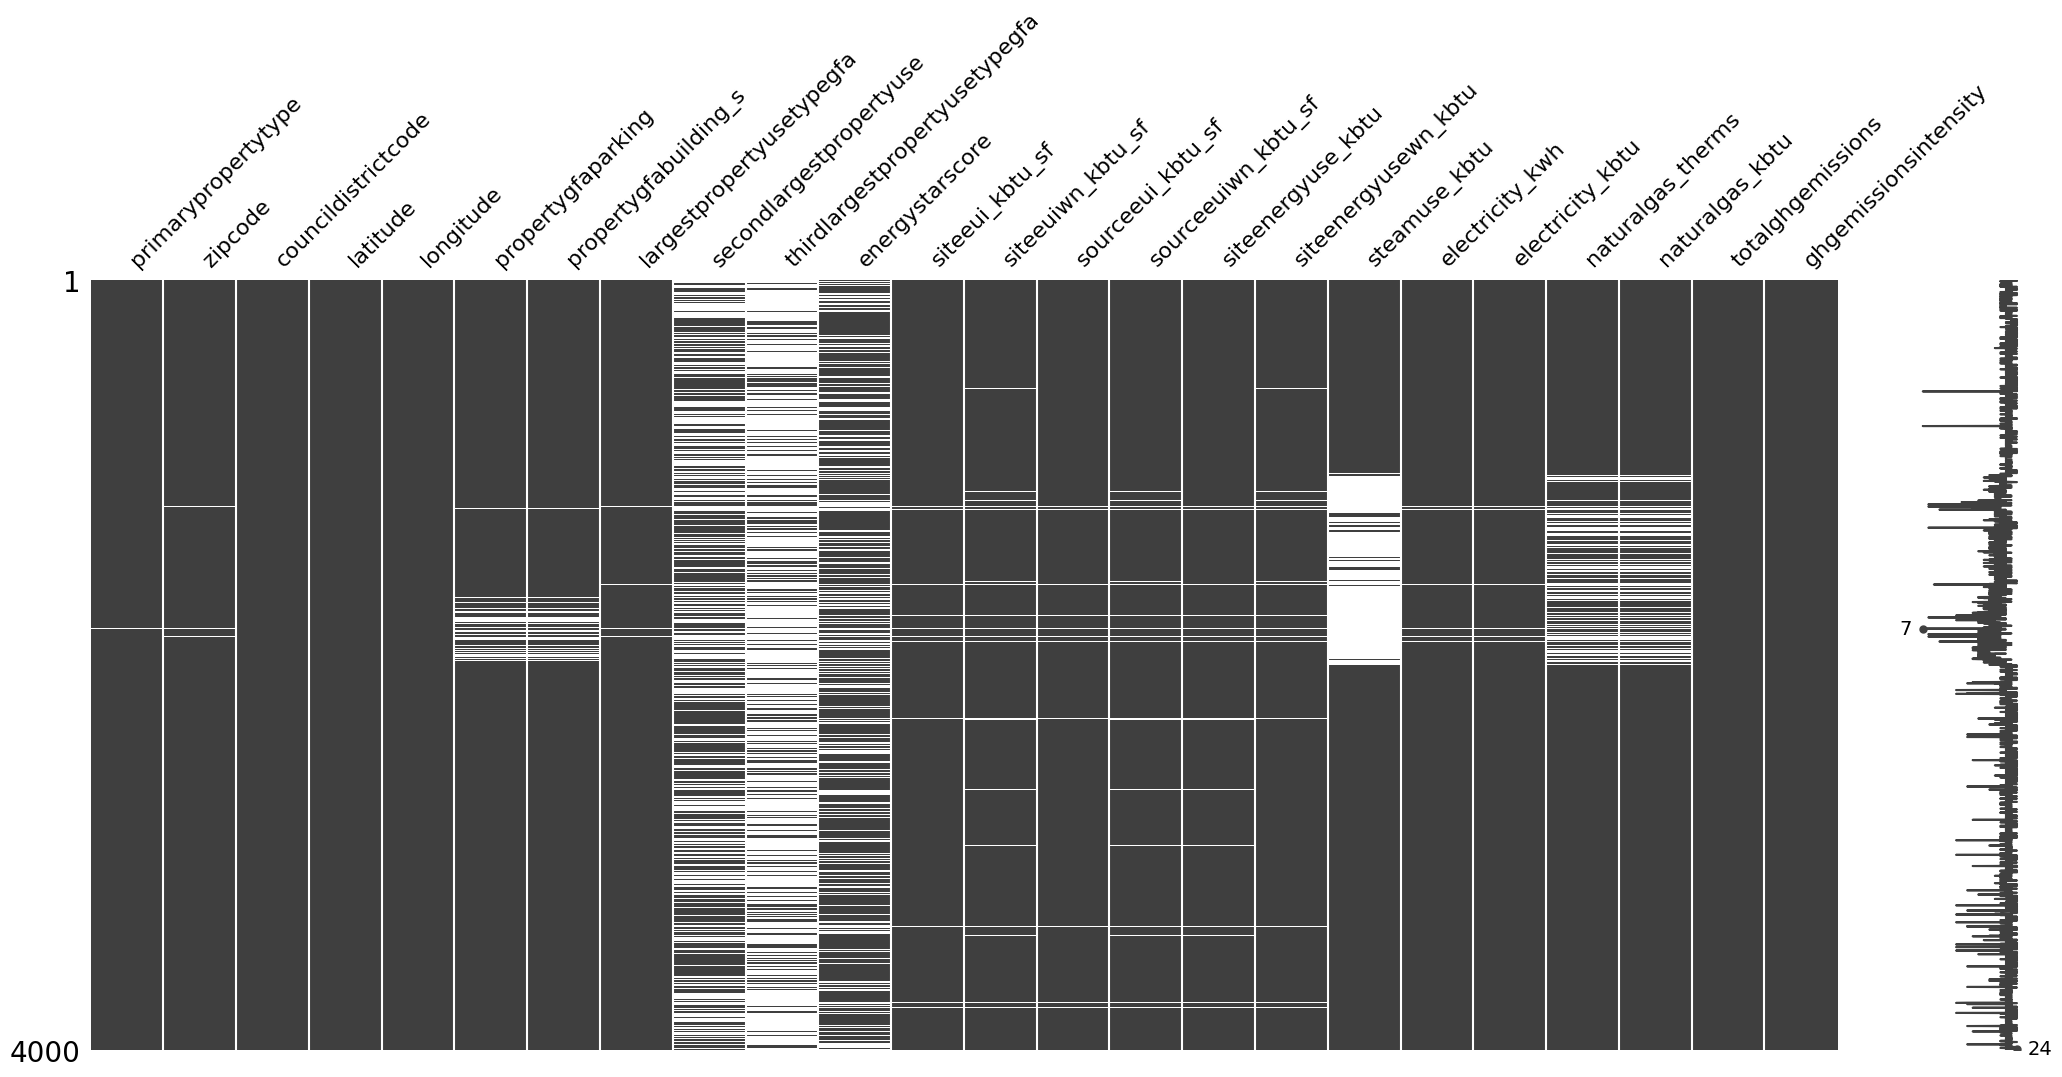

In [ ]:
df_nulls = df_2016_2019_train[df_2016_2019_train.columns[df_2016_2019_train.isna().any()]]
msno.matrix(df_nulls)

**1. We can observe that `thirdlargestpropertyusetypegfa`has > 50% of NaN values, and `secondlargestpropertyuse` has mostly 50% of NaN values. We will drop these variables because they are not informative.**

In [ ]:
# Drop variables "thirdlargestpropertyusetypegfa" and "secondlargestpropertyuse"

df_2016_2019_train = df_2016_2019_train.drop(columns=['thirdlargestpropertyusetypegfa', 'secondlargestpropertyuse'])

**2. Amoung variables with NaNs only one variable (`primarypropertytype`) is categorical. As it has only 0.33 % of NaN variables, lets replace them with the most occured category.**

In [ ]:
df_nulls = df_2016_2019_train[df_2016_2019_train.columns[df_2016_2019_train.isna().any()]]
df_nulls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   primarypropertytype        3987 non-null   object 
 1   zipcode                    3993 non-null   float64
 2   councildistrictcode        3997 non-null   float64
 3   latitude                   3997 non-null   float64
 4   longitude                  3997 non-null   float64
 5   propertygfaparking         3815 non-null   float64
 6   propertygfabuilding_s      3815 non-null   float64
 7   largestpropertyusetypegfa  3977 non-null   float64
 8   energystarscore            2894 non-null   float64
 9   siteeui_kbtu_sf            3947 non-null   float64
 10  siteeuiwn_kbtu_sf          3918 non-null   float64
 11  sourceeui_kbtu_sf          3948 non-null   float64
 12  sourceeuiwn_kbtu_sf        3919 non-null   float64
 13  siteenergyuse_kbtu         3926 non-null   float

In [ ]:
print("The most frequently occurring value is: ", df_2016_2019_train['primarypropertytype'].mode()[0])
df_2016_2019_train['primarypropertytype'] = df_2016_2019_train['primarypropertytype'].fillna(value=df_2016_2019_train['primarypropertytype'].mode()[0])

The most frequently occurring value is:  Office


**3. Now, let's replace all NaNs in variables, where percentage of NaNs < 10% with the median.**  

In [ ]:
df_nulls = df_2016_2019_train[df_2016_2019_train.columns[df_2016_2019_train.isna().any()]]
cols_with_nans = (df_nulls.isnull().sum() * 100 / len(df_nulls))[df_nulls.isnull().sum() * 100 / len(df_nulls) <= 10].index

for column in cols_with_nans:
  df_2016_2019_train[column] = df_2016_2019_train[column].fillna(value=df_2016_2019_train[column].median())

**4. Only two varibles with NaNs are left. Let's look at them in more details to undestand the optimal way for NaNs replacement.**

In [ ]:
df_nulls = df_2016_2019_train[df_2016_2019_train.columns[df_2016_2019_train.isna().any()]]
df_nulls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   energystarscore  2894 non-null   float64
 1   steamuse_kbtu    3083 non-null   float64
dtypes: float64(2)
memory usage: 62.6 KB


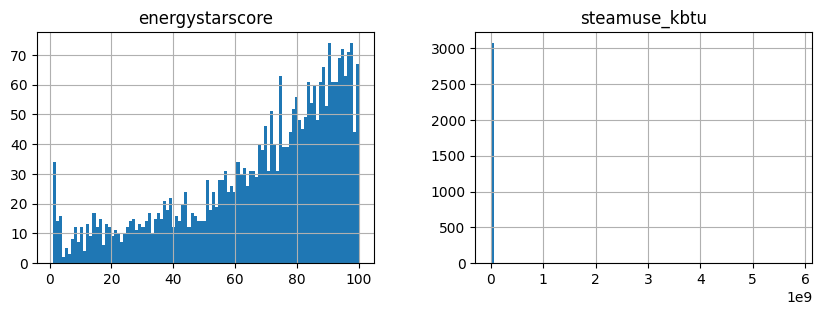

In [ ]:
df_nulls.hist(bins=100, figsize=(10, 3))
plt.show()

**4.1 `energystarscore` can be replaced with Median.**

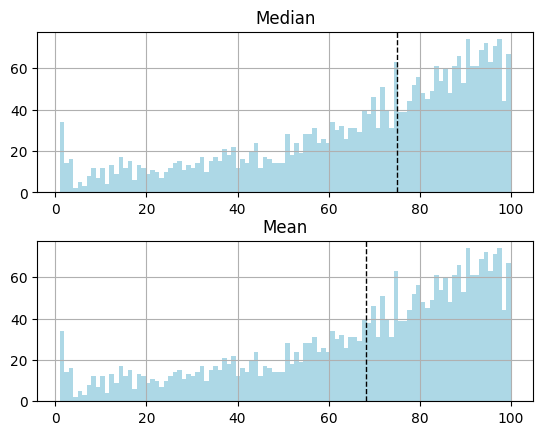

In [ ]:
fig, axes = plt.subplots(2)

df_nulls.hist('energystarscore', bins=100, ax=axes[0], color ='lightblue')
axes[0].axvline(df_nulls['energystarscore'].median(), color='k', linestyle='dashed', linewidth=1)
axes[0].set_title("Median")


df_nulls.hist('energystarscore', bins=100, ax=axes[1], color ='lightblue')
axes[1].axvline(df_nulls['energystarscore'].mean(), color='k', linestyle='dashed', linewidth=1, label='{:5.0f}'.format(df_nulls['energystarscore'].mean()))
axes[1].set_title("Mean")
plt.show()

In [ ]:
# Replace with median
print("Median of `energystarscore` = ", df_2016_2019_train['energystarscore'].median())
df_2016_2019_train['energystarscore'] = df_2016_2019_train['energystarscore'].fillna(value=df_2016_2019_train['energystarscore'].median())

Median of `energystarscore` =  75.0


**4.2 We can observe from histogram that `steamuse_kbtu` has problem with outliers. => We cannot take mean or median for NaN replacement. Let's drop outliers from the data and then replace.**

In [ ]:
df_nulls = df_2016_2019_train[df_2016_2019_train.columns[df_2016_2019_train.isna().any()]]
df_nulls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   steamuse_kbtu  3083 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


In [ ]:
pd.value_counts(df_nulls.steamuse_kbtu)

0.000000e+00    2740
1.077750e+07       1
5.531580e+05       1
3.700240e+05       1
8.015470e+05       1
                ... 
8.308140e+04       1
7.707185e+05       1
3.635556e+06       1
1.237668e+08       1
1.318900e+06       1
Name: steamuse_kbtu, Length: 344, dtype: int64

In [ ]:
df_nulls['steamuse_kbtu'].nunique()

344

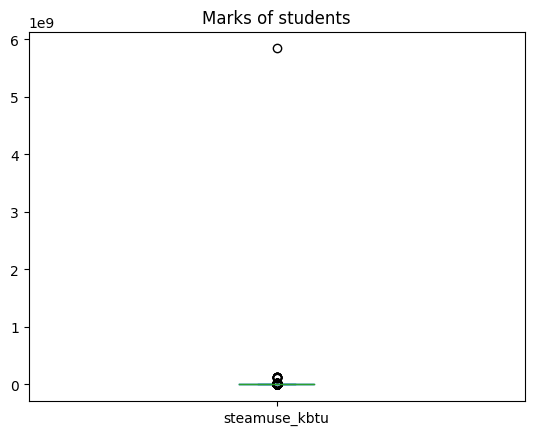

In [ ]:
df_nulls['steamuse_kbtu'].plot(kind='box', title='Marks of students')
plt.show()

**Lets try dropping the outliers:**

In [ ]:
# calculate IQR for column Height
Q1 = df_nulls['steamuse_kbtu'].quantile(0.25)
Q3 = df_nulls['steamuse_kbtu'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = df_nulls[(df_nulls['steamuse_kbtu'] < Q1 - threshold * IQR) | (df_nulls['steamuse_kbtu'] > Q3 + threshold * IQR)]
outliers

,steamuse_kbtu
0,2.003882e+06
2,2.156655e+07
3,2.214446e+06
7,2.276286e+06
9,1.039735e+06
...,...
3864,1.452447e+06
3865,8.271160e+05
3957,2.522488e+06
3970,1.390467e+06


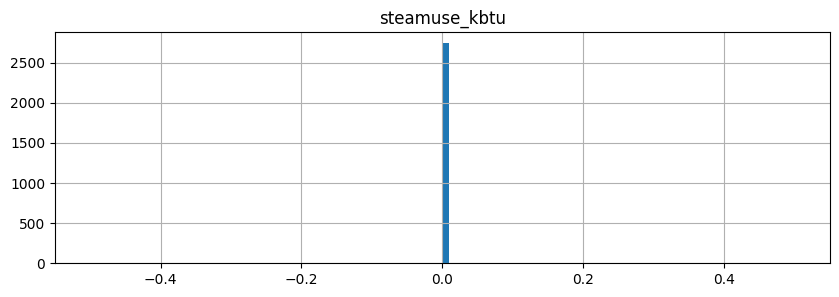

In [ ]:
# Drop outliers
df_nulls = df_nulls.drop(outliers.index)

df_nulls.hist(bins=100, figsize=(10, 3))
plt.show()

In [ ]:
df_nulls.describe()

,steamuse_kbtu
count,2740.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


We can observe that 2740 of values in `steamuse_kbtu` column = 0. And only 343 observations out of 3083 have meaningful values. => This variable does not have enough data to replace NaNs. Not informativa variable. => It should be dropped.

In [ ]:
# Drop "steamuse_kbtu" variable
df_2016_2019_train = df_2016_2019_train.drop(columns = ['steamuse_kbtu'])

In [ ]:
#Check if any Nans left
df_2016_2019_train.isna().any()

datayear                     False
buildingtype                 False
primarypropertytype          False
zipcode                      False
councildistrictcode          False
latitude                     False
longitude                    False
yearbuilt                    False
numberoffloors               False
propertygfatotal             False
propertygfaparking           False
propertygfabuilding_s        False
largestpropertyusetypegfa    False
energystarscore              False
siteeui_kbtu_sf              False
siteeuiwn_kbtu_sf            False
sourceeui_kbtu_sf            False
sourceeuiwn_kbtu_sf          False
siteenergyuse_kbtu           False
siteenergyusewn_kbtu         False
electricity_kwh              False
electricity_kbtu             False
naturalgas_therms            False
naturalgas_kbtu              False
compliancestatus             False
totalghgemissions            False
ghgemissionsintensity        False
dtype: bool

In [ ]:
# msno.matrix(df_2016_2019_train)

In [ ]:
#msno.matrix(df_2016_2019_train.sort_values('electricity_kwh'))

In [ ]:
#df_2016_2019_train.electricity_kwh.isna().sum()

In [ ]:
#df_2016_2019_train.dropna(subset='electricity_kwh', how='any', inplace=True)

In [ ]:
#df_2016_2019_train.buildingtype.unique()

In [ ]:
#df_2016_2019_train.primarypropertytype.unique()

In [ ]:
#df_2016_2019_train.primarypropertytype.isna().sum()

In [ ]:
#df_2016_2019_train[df_2016_2019_train.primarypropertytype.isna()]

In [ ]:
#df_2016_2019_train.groupby('compliancestatus')['osebuildingid'].count()

## Data Types and Categorical Variables (done)



In [ ]:
#Output all categorical variables
df_categorical = df_2016_2019_train.select_dtypes(include=['object'])
df_categorical

,buildingtype,primarypropertytype,compliancestatus
0,NonResidential,Hotel,Compliant
1,NonResidential,Hotel,Compliant
2,NonResidential,Hotel,Compliant
3,NonResidential,Hotel,Compliant
4,NonResidential,Hotel,Compliant
...,...,...,...
3995,NonResidential,Mixed Use Property,Compliant
3996,Multifamily MR (5-9),Multifamily Housing,Compliant
3997,NonResidential,Other,Compliant
3998,Multifamily MR (5-9),Multifamily Housing,Compliant


**1.`buildingtype` variable:**

In [ ]:
print("Number of unique values in `buildingtype`:", df_categorical.buildingtype.nunique())
pd.value_counts(df_categorical.buildingtype)

Number of unique values in `buildingtype`: 7


NonResidential          2608
Multifamily LR (1-4)     533
Multifamily MR (5-9)     388
SPS-District K-12        230
Nonresidential COS       101
Multifamily HR (10+)      71
Campus                    69
Name: buildingtype, dtype: int64

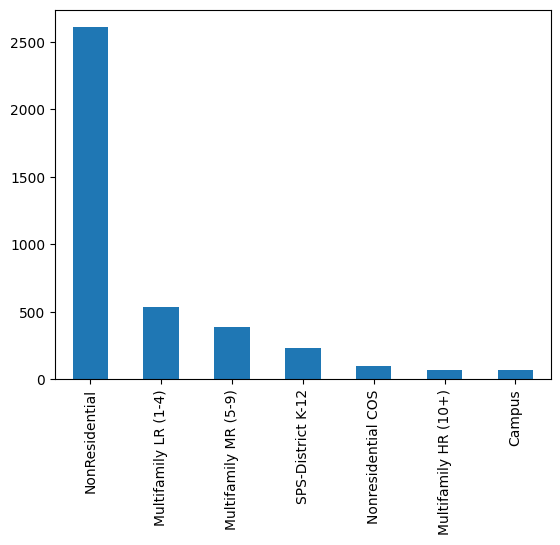

In [ ]:
df_categorical['buildingtype'].value_counts().plot(kind='bar')
plt.show()

Combine "NonResidential", "Nonresidential COS" in "Nonresidential"

Combine "Multifamily LR (1-4)", "Multifamily MR (5-9)", "Multifamily HR (10+)" in "Multifamily"

Combine "SPS-District K-12" and "Campus" in "Others"

In [ ]:
# Combine values of variables

df_2016_2019_train.loc[(df_2016_2019_train['buildingtype'] == 'NonResidential'), 'buildingtype'] = 'Nonresidential'
df_2016_2019_train.loc[(df_2016_2019_train['buildingtype'] == 'Nonresidential COS'),  'buildingtype'] = 'Nonresidential'

df_2016_2019_train.loc[(df_2016_2019_train['buildingtype'] == 'Multifamily LR (1-4)'), 'buildingtype'] = 'Multifamily'
df_2016_2019_train.loc[(df_2016_2019_train['buildingtype'] == 'Multifamily MR (5-9)'),  'buildingtype'] = 'Multifamily'
df_2016_2019_train.loc[(df_2016_2019_train['buildingtype'] == 'Multifamily HR (10+)'), 'buildingtype'] = 'Multifamily'

df_2016_2019_train.loc[(df_2016_2019_train['buildingtype'] == 'SPS-District K-12'), 'buildingtype'] = 'Other'
df_2016_2019_train.loc[(df_2016_2019_train['buildingtype'] == 'Campus'), 'buildingtype'] = 'Other'

print("Updated number of unique values in `buildingtype`:", df_2016_2019_train.buildingtype.nunique())
pd.value_counts(df_2016_2019_train.buildingtype)

Updated number of unique values in `buildingtype`: 3


Nonresidential    2709
Multifamily        992
Other              299
Name: buildingtype, dtype: int64

Let's create dummy variables:

In [ ]:
# Create dummy variables insted of "buildingtype" variable
dummy = pd.get_dummies(df_2016_2019_train['buildingtype'])
df_2016_2019_train = pd.concat([df_2016_2019_train, dummy], axis = 1)
df_2016_2019_train = df_2016_2019_train.drop(columns = ['buildingtype'])
df_2016_2019_train[['Multifamily', 'Nonresidential', 'Nonresidential']]

,Multifamily,Nonresidential,Nonresidential
0,0,1,1
1,0,1,1
2,0,1,1
3,0,1,1
4,0,1,1
...,...,...,...
3995,0,1,1
3996,1,0,0
3997,0,1,1
3998,1,0,0


**2. `primarypropertytype` variable:**

In [ ]:
print("Number of unique values in `primarypropertytype`:", df_categorical.primarypropertytype.nunique())
print(pd.value_counts(df_categorical.primarypropertytype))

Number of unique values in `primarypropertytype`: 61
Office                                        513
Multifamily Housing                           496
Large Office                                  307
K-12 School                                   262
Low-Rise Multifamily                          257
                                             ... 
Other/Specialty Hospital                        2
Library                                         2
Police Station                                  2
Outpatient Rehabilitation/Physical Therapy      1
Wholesale Club/Supercenter                      1
Name: primarypropertytype, Length: 61, dtype: int64


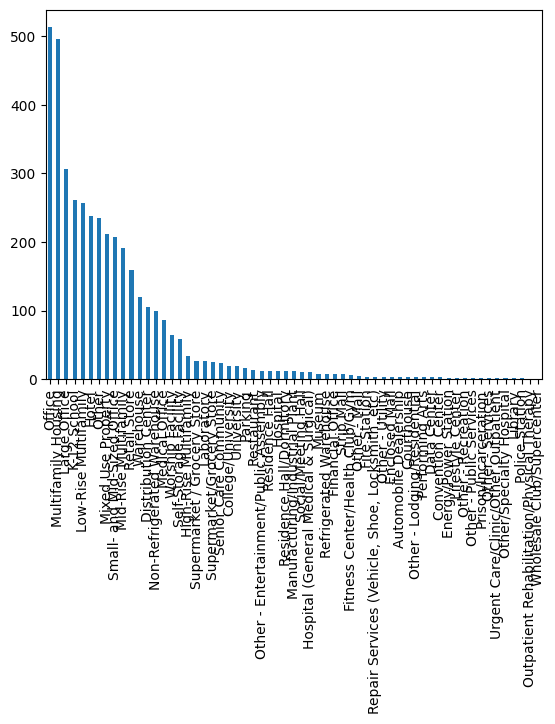

In [ ]:
df_categorical['primarypropertytype'].value_counts().plot(kind='bar')
plt.show()

Let's drop for now.

In [ ]:
# Drop "primarypropertytype" variable
df_2016_2019_train = df_2016_2019_train.drop(columns = ['primarypropertytype'])
df_2016_2019_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   datayear                   4000 non-null   int64  
 1   zipcode                    4000 non-null   float64
 2   councildistrictcode        4000 non-null   float64
 3   latitude                   4000 non-null   float64
 4   longitude                  4000 non-null   float64
 5   yearbuilt                  4000 non-null   int64  
 6   numberoffloors             4000 non-null   int64  
 7   propertygfatotal           4000 non-null   int64  
 8   propertygfaparking         4000 non-null   float64
 9   propertygfabuilding_s      4000 non-null   float64
 10  largestpropertyusetypegfa  4000 non-null   float64
 11  energystarscore            4000 non-null   float64
 12  siteeui_kbtu_sf            4000 non-null   float64
 13  siteeuiwn_kbtu_sf          4000 non-null   float

**3. `compliancestatus` variable:**

In [ ]:
print("Number of unique values in `compliancestatus`:", df_categorical.compliancestatus.nunique())
pd.value_counts(df_categorical.compliancestatus)

Number of unique values in `compliancestatus`: 7


Compliant                        3702
Not Compliant                     180
Error - Correct Default Data       51
Account Requires Verification      43
Missing Data                       13
Non-Compliant                      10
Connection Error                    1
Name: compliancestatus, dtype: int64

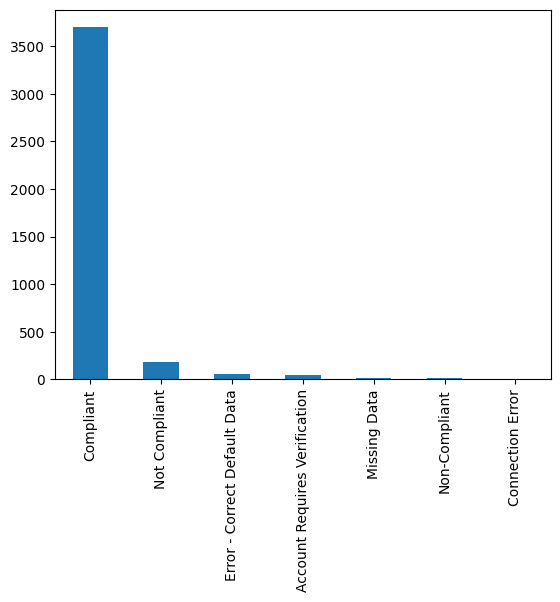

In [ ]:
df_categorical['compliancestatus'].value_counts().plot(kind='bar')
plt.show()

We can see that most of obsevations in `compliancestatus` have value "Compliant". => Let's create boolean variable istead of categorical, where  `compliancestatus` == 1 if "Compliant", and 0 if not.

In [ ]:
# Make "compliancestatus" boolean variable

df_2016_2019_train.loc[(df_2016_2019_train['compliancestatus'] == 'Compliant'), 'compliancestatus_bool'] = 1
df_2016_2019_train.loc[~(df_2016_2019_train['compliancestatus'] == 'Compliant'),  'compliancestatus_bool'] = 0
df_2016_2019_train = df_2016_2019_train.drop(columns = ['compliancestatus'])
df_2016_2019_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   datayear                   4000 non-null   int64  
 1   zipcode                    4000 non-null   float64
 2   councildistrictcode        4000 non-null   float64
 3   latitude                   4000 non-null   float64
 4   longitude                  4000 non-null   float64
 5   yearbuilt                  4000 non-null   int64  
 6   numberoffloors             4000 non-null   int64  
 7   propertygfatotal           4000 non-null   int64  
 8   propertygfaparking         4000 non-null   float64
 9   propertygfabuilding_s      4000 non-null   float64
 10  largestpropertyusetypegfa  4000 non-null   float64
 11  energystarscore            4000 non-null   float64
 12  siteeui_kbtu_sf            4000 non-null   float64
 13  siteeuiwn_kbtu_sf          4000 non-null   float

## The Target Variable (done)

The target values is `SiteEnergyUse(kBtu)` (`"siteenergyuse_kbtu"`).

`SiteEnergyUse(kBtu)`(`"siteenergyuse_kbtu"`) - The annual amount of energy consumed by the property from all sources of energy.

`SiteEnergyUseWN(kBtu)`(`"siteenergyusewn_kbtu"`) - The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions. - drop this variable later

In order to avoid overfit, we should drop `SiteEnergyUseWN(kBtu)` variable.

In [ ]:
#Drop "siteenergyusewn_kbtu" variable

df_2016_2019_train = df_2016_2019_train.drop(columns = ['siteenergyusewn_kbtu'])
df_2016_2019_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   datayear                   4000 non-null   int64  
 1   zipcode                    4000 non-null   float64
 2   councildistrictcode        4000 non-null   float64
 3   latitude                   4000 non-null   float64
 4   longitude                  4000 non-null   float64
 5   yearbuilt                  4000 non-null   int64  
 6   numberoffloors             4000 non-null   int64  
 7   propertygfatotal           4000 non-null   int64  
 8   propertygfaparking         4000 non-null   float64
 9   propertygfabuilding_s      4000 non-null   float64
 10  largestpropertyusetypegfa  4000 non-null   float64
 11  energystarscore            4000 non-null   float64
 12  siteeui_kbtu_sf            4000 non-null   float64
 13  siteeuiwn_kbtu_sf          4000 non-null   float

In [ ]:
print(df_2016_2019_train['siteenergyuse_kbtu'].describe())

count    4.000000e+03
mean     1.179746e+07
std      9.995955e+07
min      0.000000e+00
25%      1.759337e+06
50%      3.954126e+06
75%      9.177614e+06
max      6.063691e+09
Name: siteenergyuse_kbtu, dtype: float64


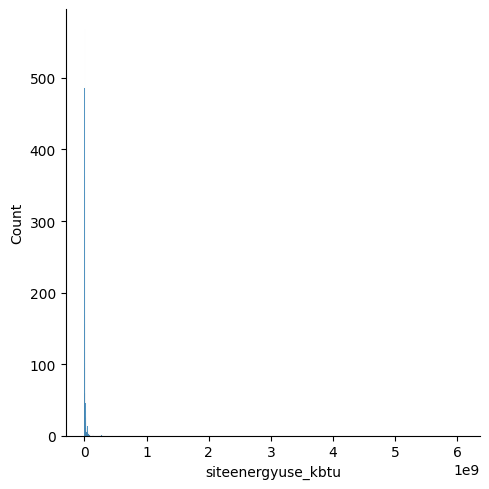

In [ ]:
sns.displot(df_2016_2019_train, x = 'siteenergyuse_kbtu')
plt.show()

It seems like target varible has problem with outliers.

In [ ]:
df_target = df_2016_2019_train[['siteenergyuse_kbtu']]
df_target

,siteenergyuse_kbtu
0,7226362.5
1,8387933.0
2,72587024.0
3,6794584.0
4,14172606.0
...,...
3995,1328430.0
3996,6152096.0
3997,3076972.0
3998,3768958.0


In [ ]:
# calculate IQR for column Height
Q1 = df_target['siteenergyuse_kbtu'].quantile(0.25)
Q3 = df_target['siteenergyuse_kbtu'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 2
outliers = df_target[(df_target['siteenergyuse_kbtu'] < Q1 - threshold * IQR) | (df_target['siteenergyuse_kbtu'] > Q3 + threshold * IQR)]
outliers

,siteenergyuse_kbtu
2,72587024.0
11,26941110.0
17,33556756.0
20,44984468.0
21,47859812.0
...,...
3566,89917528.0
3604,275296608.0
3796,26808334.0
3797,36729196.0


The number of outliers = 350. We can drop them.

In [ ]:
df_2016_2019_train = df_2016_2019_train.drop(outliers.index)
df_2016_2019_train = df_2016_2019_train.reset_index(drop=True)
df_2016_2019_train

,datayear,zipcode,councildistrictcode,latitude,longitude,yearbuilt,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,...,electricity_kwh,electricity_kbtu,naturalgas_therms,naturalgas_kbtu,totalghgemissions,ghgemissionsintensity,Multifamily,Nonresidential,Other,compliancestatus_bool
0,2016,98101.0,7.0,47.61220,-122.33799,1927,12,88434,0.0,88434.0,...,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,2.83,0,1,0,1.0
1,2016,98101.0,7.0,47.61317,-122.33393,1996,11,103566,15064.0,88502.0,...,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,2.86,0,1,0,1.0
2,2016,98101.0,7.0,47.61412,-122.33664,1926,10,61320,0.0,61320.0,...,8.115253e+05,2768924.0,18112.13086,1811213.0,286.43,4.67,0,1,0,1.0
3,2016,98121.0,7.0,47.61375,-122.34047,1980,18,175580,62000.0,113580.0,...,1.573449e+06,5368607.0,88039.98438,8803998.0,505.01,2.88,0,1,0,1.0
4,2016,98101.0,7.0,47.61623,-122.33657,1999,2,97288,37198.0,60090.0,...,2.160444e+06,7371434.0,47151.81641,4715182.0,301.81,3.10,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,2019,98125.0,5.0,47.72178,-122.29498,1979,1,39350,0.0,39350.0,...,8.497800e+04,289946.0,10431.00000,1043058.0,57.20,1.50,0,1,0,1.0
3646,2019,98125.0,1.0,47.72235,-122.29584,2008,6,193691,34414.0,159277.0,...,1.205828e+06,4114285.0,20229.00000,2022851.0,132.80,0.80,1,0,0,1.0
3647,2019,98125.0,5.0,47.72032,-122.29507,1949,1,22405,0.0,22405.0,...,3.354470e+05,1144544.0,19381.00000,1938090.0,110.00,4.90,0,1,0,1.0
3648,2019,98125.0,5.0,47.72082,-122.29195,1971,7,86283,0.0,86283.0,...,8.751200e+05,2985909.0,7336.00000,733604.0,57.40,0.70,1,0,0,1.0


The new distribution of target variable `siteenergyuse_kbtu`:

* We can see that it is right skewed

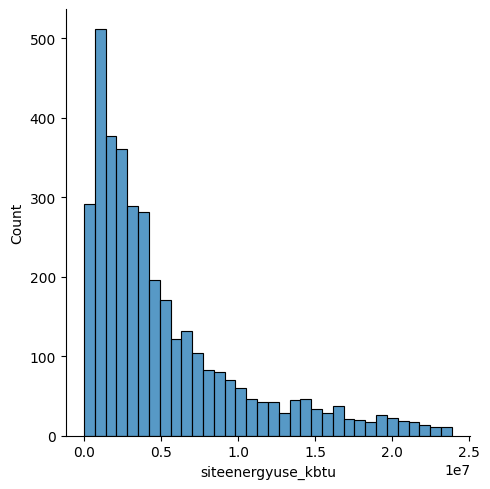

In [ ]:
sns.displot(df_2016_2019_train, x = 'siteenergyuse_kbtu')

## Data Statistics (TODO)

**1. We might want to check correlations between features, as they would show us whether we have any multicollinearity issues:**


In [ ]:
# TODO:

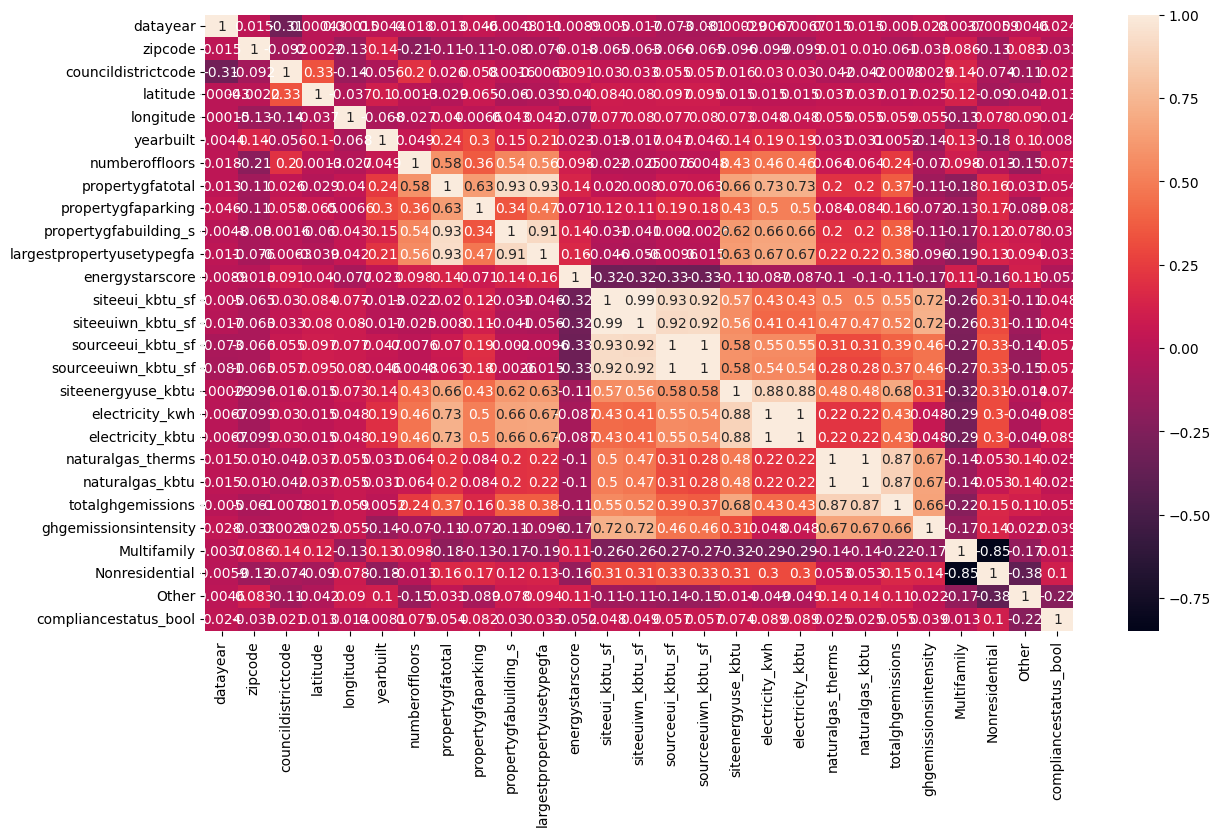

In [ ]:
plt.figure(figsize=(14, 8))
ax = sns.heatmap(df_2016_2019_train.corr(), annot=True)

**2. Let's look at the distribution of all of the features by ploting them.**

In [ ]:
#TODO

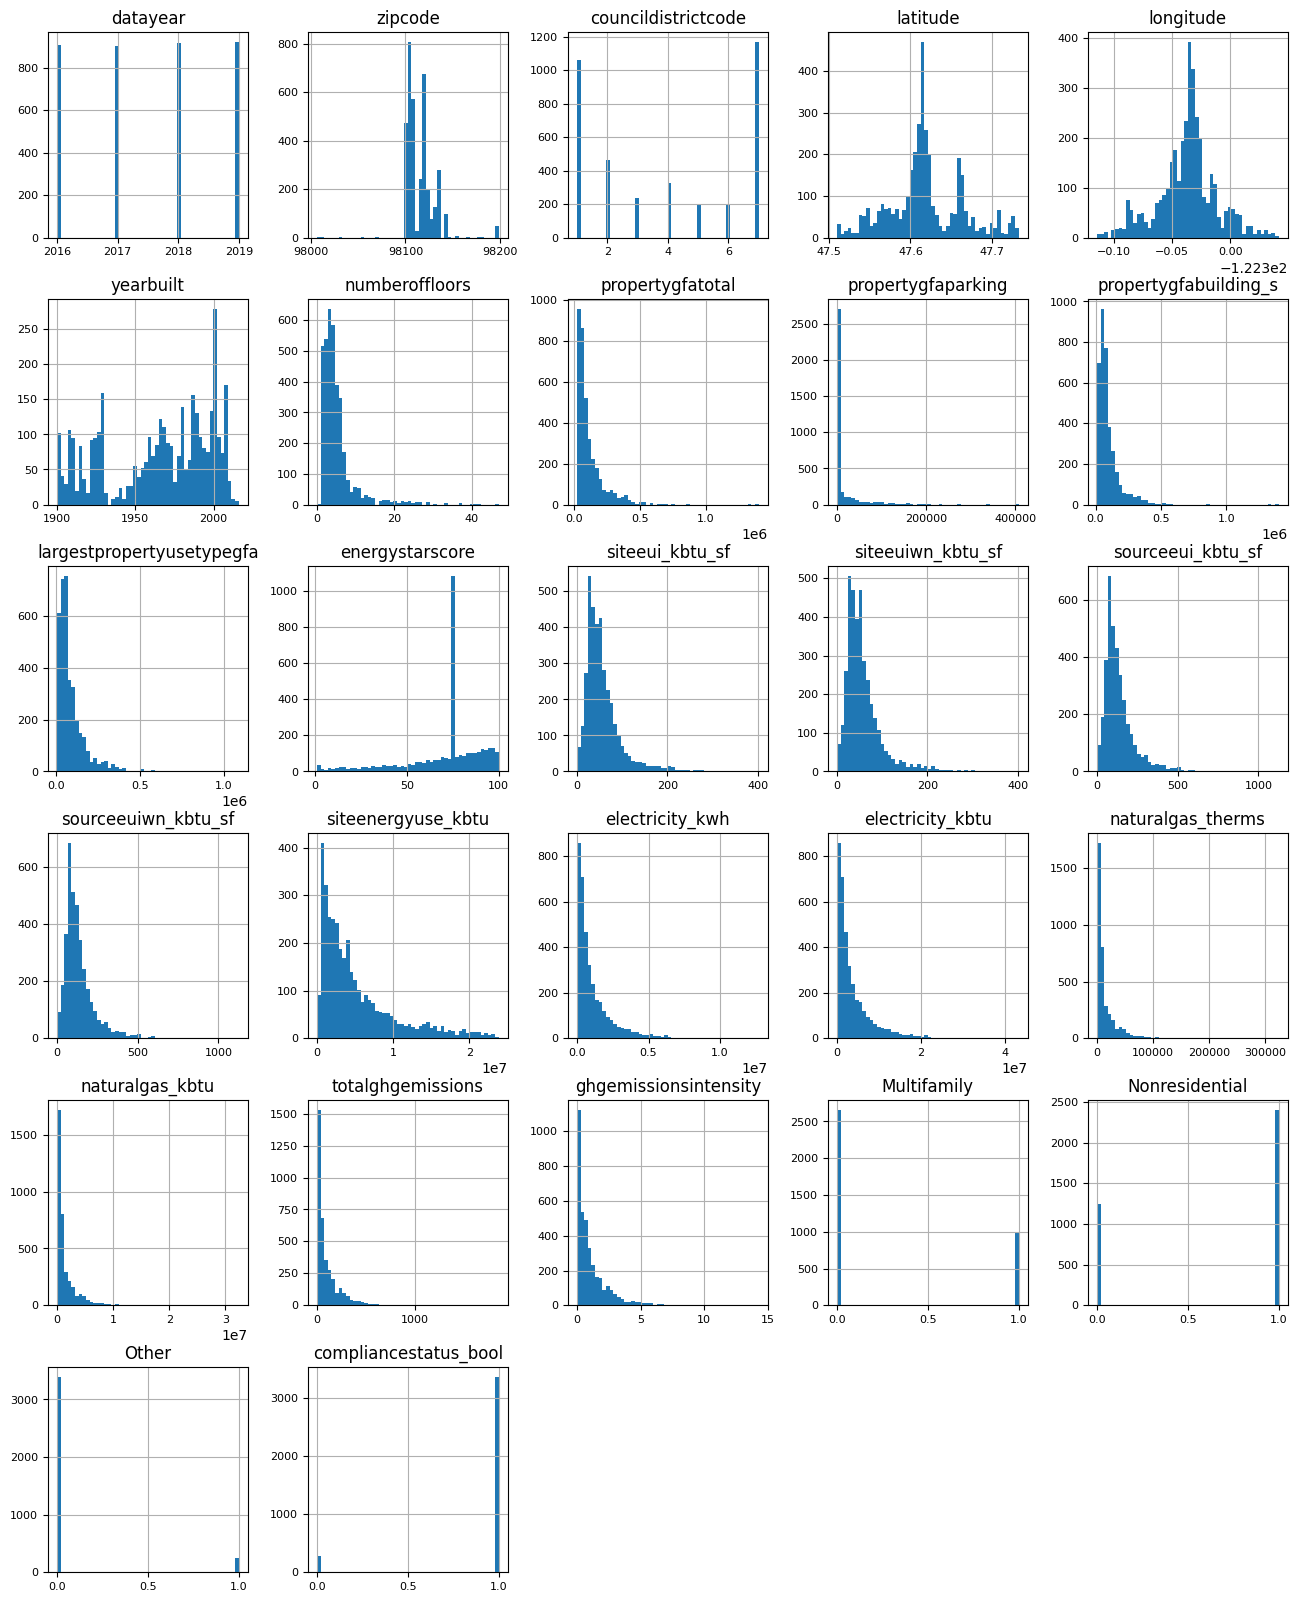

In [ ]:
df_2016_2019_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

**3. Outliers(Correlation is affected by outliers)**

So we could proceed as follow:

3.1. Plot the numerical features and see which ones have very few or explainable outliers

3.2. Remove the outliers from these features and see which one can have a good correlation without their outliers

In [ ]:
#TODO

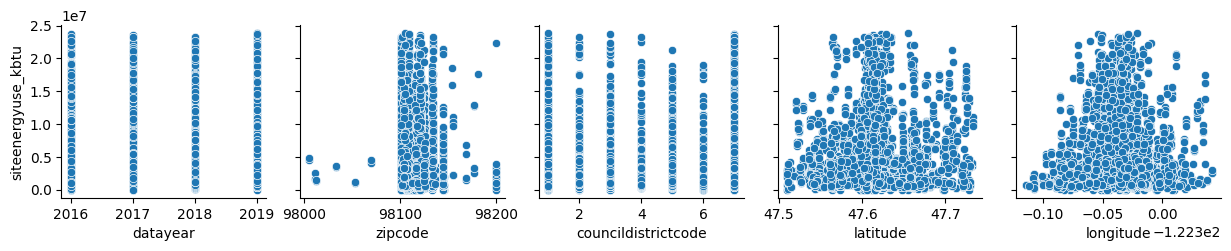

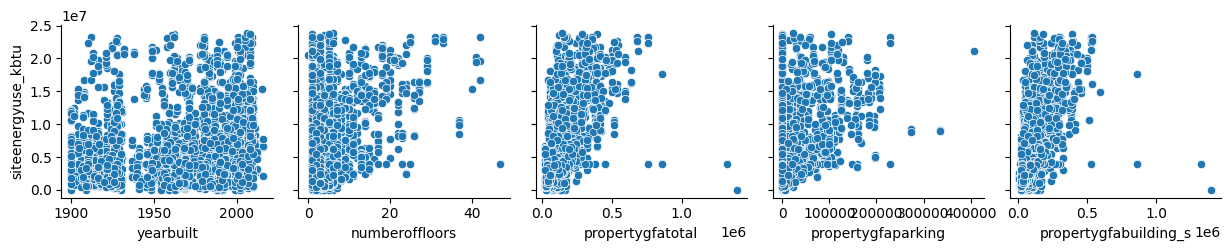

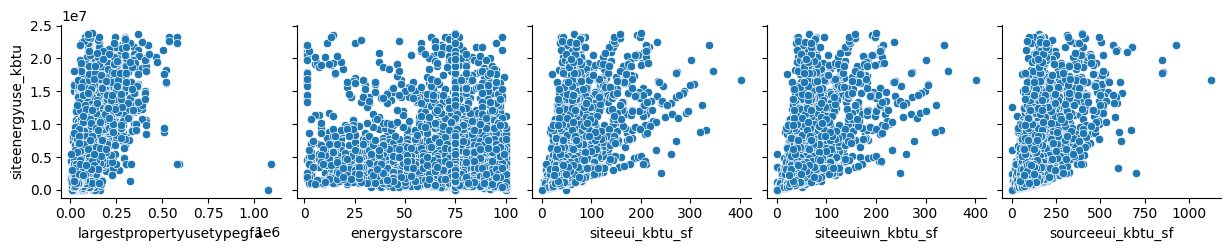

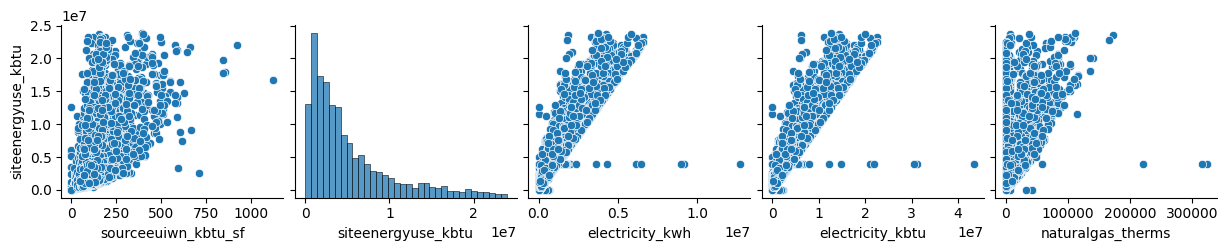

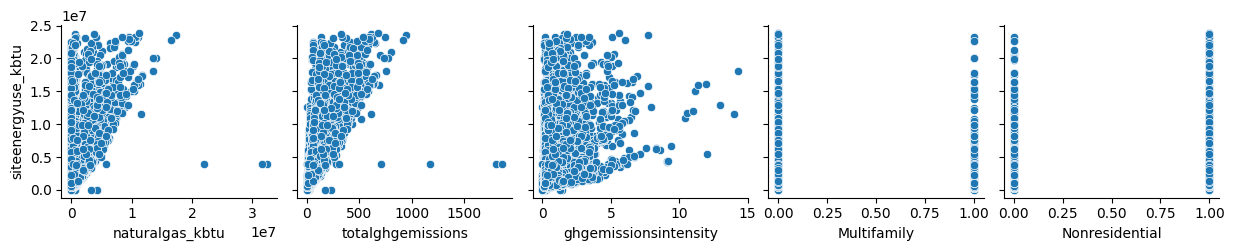

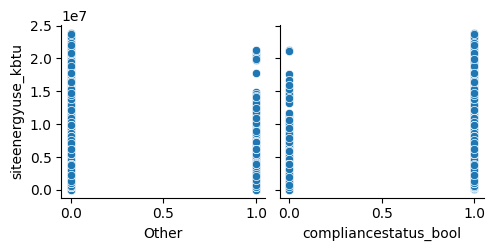

In [ ]:
#scatterplots of each variable againts target

for i in range(0, len(df_2016_2019_train.columns), 5):
    sns.pairplot(data=df_2016_2019_train,
                x_vars=df_2016_2019_train.columns[i:i+5],
                y_vars=['siteenergyuse_kbtu'])

#**Model**

**Task:** For each unique property predict annual amount of energy consumed in 2020 and 2021 based on the data from 2016 - 2019. Train model only on train and validation sets from 2016 - 2019.

**OSEBuildingID** - A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.

**siteenergyuse_kbtu** - The annual amount of energy consumed by the property from all sources of energy. (Output variable)


## Baseline Model (TODO)

In [ ]:
# TODO
# standardize data or log transform
# Create train, validation set (split data)
# Train the model on train set (Linear Regression, can try KNN regression)
# Test the model on validation set

**!!!!TODO:!!!!**

*We should drop variables that are related to energy consumption before training model. As we want to predict consumption based on the building info, not just calculating it from other variables.*

In [ ]:
#TODO: Drop variables

In [ ]:
#Train validation split
target_variable = 'siteenergyuse_kbtu'
X_train, X_test, y_train, y_test = tts(df_2016_2019_train.drop(target_variable, axis=1), df_2016_2019_train[target_variable], test_size = 0.2, random_state=0)
print(f'Sanity check for dimensions of variables: {X_train.shape, X_test.shape, y_train.shape, y_test.shape}')

Sanity check for dimensions of variables: ((2920, 26), (730, 26), (2920,), (730,))


In [ ]:
# Linear Regression
mdl = sm.OLS(y_train, X_train)     # training on train observations
fmdl = mdl.fit()
print(fmdl.summary(title='Baseline model', alpha=.01))
y_pred = fmdl.predict(X_test)   # predicted values on the testing set
print(f'Out of sample R^2 is {r2_score(y_test, y_pred):.2f}')

                                Baseline model                                
Dep. Variable:     siteenergyuse_kbtu   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1382.
Date:                Sat, 28 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:43:33   Log-Likelihood:                -45496.
No. Observations:                2920   AIC:                         9.104e+04
Df Residuals:                    2894   BIC:                         9.120e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.005      0.995]
---------------------------------------------------------------------------------------------
datayear              

#**Comparative analysis**

In [ ]:
# TODO
# Predict 2020/2021 consumption using our trained model
# Compare predicted data with real

In [ ]:
# Using the information about Building Energy Benchmarking we will predict for 1000 building in Seattle possible consumption

#**Conclusions**

In [ ]:
# TODO

# Glossary

* Gross Floor Area (GFA) <br>
The total number of square feet measured between the
exterior surfaces of the enclosing fixed walls of a building, including all supporting functions such as offices, lobbies, restrooms, equipment storage areas, mechanical rooms, break rooms and elevator shafts